In [1]:
# библиотеки общего назначения
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D


# для работы с файлами
import glob



# для построения суррогатных моделей
import sklearn.metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator

# LS - The Least square model
from smt.surrogate_models import LS, KRG

# RBF из SMT не подключается (из другой библиотеки - всё норм) [проблема именно на домашнем компьютере]
# from smt.surrogate_models import RBF

from sklearn.utils.estimator_checks import check_estimator
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

# для сохранения и загрузки суррогатных моделей
import joblib

# для работы с моим интегратором
import my3D_surface_integrator as sint



# для отслеживания прогресса
from tqdm import tqdm

# Чтение данных

In [2]:
regimes = (pd.read_csv("./data/regimes.csv")).drop(['Num'],axis=1)
M_is = pd.DataFrame(columns=np.arange(regimes.shape[0]))
Cp = pd.DataFrame(columns=np.arange(regimes.shape[0]))

files = glob.glob("data/*_*_*.csv")
files.sort()
for i,path in enumerate(files):
    M_is[i] = pd.read_csv(path)['M_is']
    Cp[i] = pd.read_csv(path)['Cp']
    
XYZ_coords = pd.read_csv(files[0]).drop(['Cp', 'M_is'], axis=1)

coefCxyz = pd.DataFrame(columns=['Cx', 'Cy', 'Cz'], data=np.zeros((regimes.shape[0],3)))

files = glob.glob("results/*_*_*")
files.sort()
for i,path in enumerate(files):
    f = open(path, mode='r')

    l = f.readlines()[22]
    sep_words = l.split()

    coefCxyz.iloc[i][0] = float(sep_words[-3])
    coefCxyz.iloc[i][1] = float(sep_words[-2])
    coefCxyz.iloc[i][2] = float(sep_words[-1])    

    f.close()

S_REF = 0.15

# Зоны крыла

In [3]:
zones_inds = []
z1 = np.arange(0,833) # верхняя часть ближней передней кромки.    "ближняя" - ближе к корпусу самолёта
z2 = np.arange(833, 13377) # нижняя часть первого блока крыла.    "первый" - отсчёт от корпуса самолёта
z3 = np.arange(13377,15009) # нижняя часть дальней передней кромки
z4 = np.arange(15009,27297) # нижняя часть второго блока крыла
z5 = np.arange(27297,39585) # нижняя часть третьего блока крыла
z6 = np.arange(39585,40369) # верхняя часть ближней передней кромки
z7 = np.arange(40369,52913) # верхняя часть первого блока крыла
z8 = np.arange(52913,54449) # верхняя часть дальней передней кромки
z9 = np.arange(54449,66737) # верхняя часть второго блока крыла
z10 = np.arange(66737,79025) # верхняя часть третьего блока крыла

# возможно, перепутан верх и низ

zones_inds.append(z1)
zones_inds.append(z2)
zones_inds.append(z3)
zones_inds.append(z4)
zones_inds.append(z5)
zones_inds.append(z6)
zones_inds.append(z7)
zones_inds.append(z8)
zones_inds.append(z9)
zones_inds.append(z10)

dims_zones = [(49, 17), (256, 49), (96, 17), (256, 48), (256, 48), 
              (49, 16), (256, 49), (96, 16), (256, 48), (256, 48)]

# Получение моих $C_x, C_y, C_z$

In [4]:
# что в папке `results`
coefCxyz

,Cx,Cy,Cz
0,0.083398,-0.298906,0.149321
1,0.024050,-0.136088,0.131233
2,0.080494,0.784640,0.152704
3,0.046048,0.701913,0.134848
4,0.043631,0.510899,0.132618
...,...,...,...
59,0.060453,0.723859,0.138587
60,0.021536,0.316106,0.123653
61,0.035199,-0.238177,0.135942
62,0.078851,0.708251,0.144728


In [47]:
# my_Cx_n_lab = np.zeros(coefCxyz.shape[0])
# my_Cy_n_lab = np.zeros(coefCxyz.shape[0])
# my_Cz_n_lab = np.zeros(coefCxyz.shape[0])


# CICLES = coefCxyz.shape[0]
# for i in tqdm(range(CICLES)):
#     Cx, Cy, Cz = sint.get_CxCyCz_LabSys_byCp(xyz_coords=XYZ_coords,
#                                              Cp=Cp[i],
#                                              Sref=S_REF, 
#                                              zones_inds=zones_inds,
#                                              dims_zones=dims_zones)
#     my_Cx_n_lab[i] = Cx
#     my_Cy_n_lab[i] = Cy
#     my_Cz_n_lab[i] = Cz

In [86]:
# AAA = np.zeros((coefCxyz.shape[0], 3))
# AAA[:, 0] = my_Cx_n_lab
# AAA[:, 1] = my_Cy_n_lab
# AAA[:, 2] = my_Cz_n_lab

# AAA_df = pd.DataFrame(AAA, columns=["Cx", "Cy", "Cz"])
# AAA_df.to_csv("./my_CxCyCz_lab")

In [5]:
AAA_df = pd.read_csv("./my_CxCyCz_lab", index_col=0)
my_Cx_n_lab = AAA_df['Cx']
my_Cy_n_lab = AAA_df['Cy']
my_Cz_n_lab = AAA_df['Cz']

In [6]:
my_Cx_n_spd = np.zeros(coefCxyz.shape[0])
my_Cy_n_spd = np.zeros(coefCxyz.shape[0])
my_Cz_n_spd = np.zeros(coefCxyz.shape[0])

In [7]:
CICLES = coefCxyz.shape[0]
for i in tqdm(range(CICLES)):
    Cx, Cy, Cz = sint.LabSys2SpdSys_CxCyCz(my_Cx_n_lab[i], my_Cy_n_lab[i], my_Cz_n_lab[i], 
                                           AngAt=regimes['alpha'][i], debug=False)
    
    my_Cx_n_spd[i] = Cx
    my_Cy_n_spd[i] = Cy
    my_Cz_n_spd[i] = Cz

100%|██████████| 64/64 [00:00<00:00, 11377.76it/s]


# Сравнение результатов

In [8]:
my_Cx_n_lab.shape

(64,)

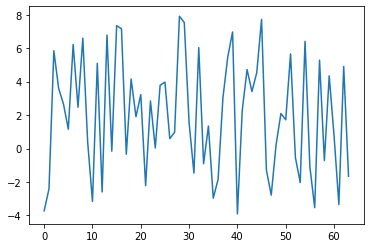

In [9]:
plt.plot(regimes['alpha'])

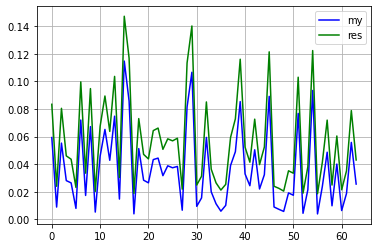

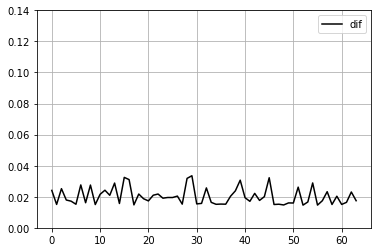

In [22]:
#Cx
plt.plot(my_Cx_n_spd, color='blue', label='my')
plt.plot(coefCxyz['Cx'], color='green', label='res')
plt.grid()
plt.legend()
plt.show()

plt.plot(np.abs(my_Cx_n_spd - coefCxyz['Cx']), color='black', label='dif')
plt.ylim(-0.0, 0.14)
plt.legend()
plt.grid()

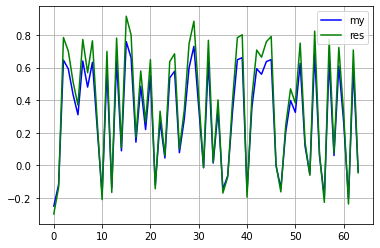

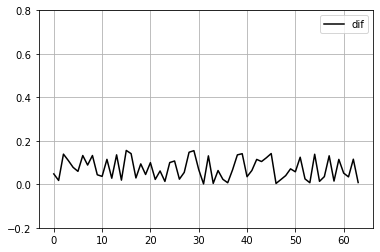

In [23]:
#Cy
plt.plot(my_Cy_n_spd, color='blue', label='my')
plt.plot(coefCxyz['Cy'], color='green', label='res')
plt.grid()
plt.legend()
plt.show()

plt.plot(np.abs(my_Cy_n_spd - coefCxyz['Cy']), color='black', label='dif')
plt.ylim(-0.2, 0.8)
plt.legend()
plt.grid()

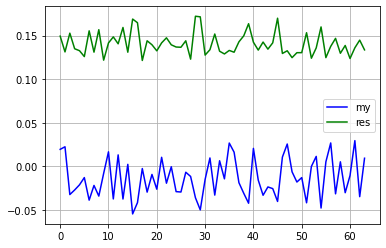

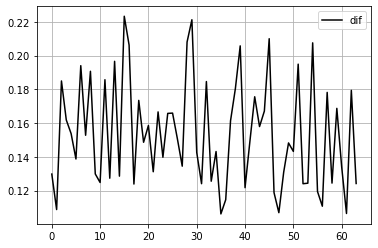

In [18]:
#Cz
plt.plot(my_Cz_n_spd, color='blue', label='my')
plt.plot(coefCxyz['Cz'], color='green', label='res')
plt.grid()
plt.legend()
plt.show()

plt.plot(np.abs(my_Cz_n_spd - coefCxyz['Cz']), color='black', label='dif')
# plt.ylim(-0., 0.17)
plt.legend()
plt.grid()